<a href="https://colab.research.google.com/github/williamcarp/Equity-Derivative-Models/blob/main/tree/main/Notebooks/CRR_Binomial_Tree_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cox-Ross-Rubenstein Binomial (CRR) Tree Pricing**

Author:       Will Carpenter

Date Created: April 1st, 2021

Description:




## Importing

In [2]:
import math 
import numpy as np 
from scipy.stats import norm # Cumulative normal distribution
import matplotlib.pyplot as plt

## CRR Binomial Tree 

The CRR binomial tree program is given below.

Space should be O(n). Runtime is O(n^2). 

In [3]:
def crr_binomial_tree(S, K, r, T, t, v, style, type):

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # Calculate time increment 
    dt = T / t 
    
    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 
    
    # Initialize tree  
    crrTree      = np.empty((t+1,t+1))
    crrTree[:]   = np.nan
    
    # Initial stock price
    crrTree[0,0] = S
    
    # Initialize tree parameters 
    u = math.exp(v*math.sqrt(dt))
    d = 1/u
    p = (math.exp(r*dt) - d)/(u - d)

    for row in range(0,t+1):
        St = S*u**(t-row)*d**(row)
        crrTree[row, t] =  max(x*St - x*K, 0)

    for col in range(t-1, -1, -1):
        for row in range(0, col+1):
            
            # Determine value of early excercise 
            if style=='euro':   earlyExercise = np.NINF
            if style=='amer':   earlyExercise = x*S*u**(col-row)*d**(row) - x*K

            # backward iteration from previous nodes
            Pu = crrTree[row, col+1]
            Pd = crrTree[row+1, col+1]
            # Determine continuation value 
            continuation = math.exp(-r*dt)*(p*Pu + (1-p)*Pd)
            
            # Calcuate price on at tree node
            crrTree[row, col] = max(continuation, earlyExercise)

    
    return crrTree[0,0]


## Black-Scholes Option Pricing Formula

By design, prices given by the CRR binomial and trinomial tree should converge to Black-Scholes pricing as the number of steps increases.

In [4]:
# Black-Scholes Model

def black_scholes(S, K, r, T, t, v, style, type):

    # Black-Scholes does not accomodate American options 

    # S  : spot price 
    # K  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : number of steps 
    # v  : annualized volatility

    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 

    d1 = (math.log(S/K) + (v**2/2 + r)*T)/(v*math.sqrt(T))
    d2 = (d1 - v*math.sqrt(T))

    return x*S*norm.cdf(x*d1) - x*K*math.exp(-r*T)*norm.cdf(x*d2)

## Visualizing the CRR Binomial Tree

Code for the CRR binomial tree can be expanded to include an additional array for the entire evolution of the underlying stock price. While this modification increases run-time and storage of the program, it can be useful to have for de-bugging purposes. 

In [6]:
# Visualizing the CRR Stock Price Tree

# Useful program for debugging purposes 
# Model parameters, stock price tree, and option price tree are printed
# This code is not optimized for memory-usage. 
# Runtime: O(n^2)
# Storage: O(n^2)

# This is the most up-to-date tree availbale for correct sizing and pricing 

def crr_visualize_tree(S, K, r, T, t, v, style, type):

    # s  : spot price 
    # k  : strike 
    # r  : riskless rate
    # T  : maturity (in yrs.)
    # t  : steps 
    # v  : annualized volatility

    # Calculate time increment 
    dt = T / t 
    
    # Set type of option 
    if type=='call': x = 1 
    if type=='put' : x = -1 
    
    # Initialize tree  
    crrTree, crrPrice         = np.empty((t+1,t+1)), np.empty((t+1,t+1)) 
    crrTree[:], crrPrice[:]   = np.nan, np.nan
    
    # Initial stock price
    crrTree[0,0] = S
    
    # Initialize tree parameters 
    u = math.exp(v*math.sqrt(dt))
    d = 1/u
    p = (math.exp(r*dt) - d)/(u - d)

    if d >= 1+r or u <= 1+r:
        raise Exception("Martingale Property not satisfied.")
    
    # Creating the stock price tree 
    # Fill in top branch 
    for col in range(1,len(crrTree)):
        crrTree[0, col] = crrTree[0, col-1]*u
    # Fill in rest of tree
    for row in range(1, len(crrTree)):
        for col in range(row, len(crrTree)):
            crrTree[row, col] = crrTree[row-1, col-1]*d
    
    for row in range(0,t+1):
        St = S*u**(t-row)*d**(row)
        crrPrice[row, t] =  max(x*St - x*K, 0)

    for col in range(t-1, -1, -1):
        for row in range(0, col+1):

            # Determine value of early excercise 
            if style=='euro': earlyExercise = np.NINF
            if style=='amer': earlyExercise = x*crrTree[row, col] - x*K

            # x*S*u**(col-row)*d**(row) - x*K

            # move backwards from previous payoffs 
            Su = crrPrice[row, col+1]
            Sd = crrPrice[row+1, col+1]

            # Determine continuation value 
            continuation = math.exp(-r*dt)*(p*Su + (1-p)*Sd)
        
            # Calcuate price on tree
            # crrPrice[row, col] = math.exp(-r*dt)*(p*Su + (1-p)*Sd)  
            crrPrice[row, col] = max(continuation, earlyExercise)

    # Added code for printing and de-bugging 

    # Reporting the model parameters
    print()
    print("Inputs:\n")
    print("T : " "{:4.2f}".format(T*12) + " months")
    print("t : " "{:4.0f}".format(t) + " periods")

    print()
    print("Tree Parameters:\n")
    print("u : " "{:3.4f}".format(u))
    print("d : " "{:3.4f}".format(d))
    print("p : " "{:3.3f}".format(p))

    # Print the stock price tree    
    print("\nCRR Stock Price Tree:\n")
    
    # for i in range(0,len(crrTree)):
    #     print("t = " "{:2.2f}".format(i), end =" ")
    # print("\n")

    for i in crrTree:
        for j in i:
            print("{:8.3f}".format(j), end=" ")
        print() 
    print("\n")

    # print the stock price tree    
    print("\nCRR Option Price Tree:\n")
    for i in crrPrice:
        for j in i:
            print("{:8.3f}".format(j), end=" ")
        print() 
    print("\n")

    print("Option Price: $" + "{:6.2f}".format(crrPrice[0,0]))
    print("______________________________________________________________")



## American Airlines

American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. The company provides scheduled air transportation services for passengers and cargo

In [19]:
# American Airlines european call option
# Date: May 14th, 2021
# Maturity: July 16th, 2021

yahoo_price = 1.38

crr_price = crr_binomial_tree(22.17, 23.00, 0.002, 2/12, 150, 0.4736, 'euro', 'call')
bs_price  =     black_scholes(22.17, 23.00, 0.002, 2/12, 150, 0.4736, 'euro', 'call')
print("________________________________________________________________\n")
print("American Airlines Group Inc.")
print()
print("CRR European Call Price:    $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price:    $" + "{:3.2f}".format(bs_price))
print("Yahoo European Call Price:  $" + "{:3.2f}".format(yahoo_price))
print("________________________________________________________________\n")

________________________________________________________________

American Airlines Group Inc.

CRR European Call Price:    $1.36
B-S European Call Price:    $1.36
Yahoo European Call Price:  $1.38
________________________________________________________________



In [23]:
crr_visualize_tree(22.17, 23.00, 0.002, 2/12, 10, 0.4736, 'euro', 'call')


Inputs:

T : 2.00 months
t :   10 periods

Tree Parameters:

u : 1.0630
d : 0.9407
p : 0.485

CRR Stock Price Tree:

  22.170   23.568   25.054   26.633   28.313   30.098   31.995   34.013   36.157   38.437   40.860 
     nan   20.855   22.170   23.568   25.054   26.633   28.313   30.098   31.995   34.013   36.157 
     nan      nan   19.618   20.855   22.170   23.568   25.054   26.633   28.313   30.098   31.995 
     nan      nan      nan   18.455   19.618   20.855   22.170   23.568   25.054   26.633   28.313 
     nan      nan      nan      nan   17.360   18.455   19.618   20.855   22.170   23.568   25.054 
     nan      nan      nan      nan      nan   16.330   17.360   18.455   19.618   20.855   22.170 
     nan      nan      nan      nan      nan      nan   15.362   16.330   17.360   18.455   19.618 
     nan      nan      nan      nan      nan      nan      nan   14.451   15.362   16.330   17.360 
     nan      nan      nan      nan      nan      nan      nan      nan   13.594  

### Test Black-Scholes for Puts

### Graph of Option Price Convergence 

[[ 10.           8.05591434   8.03230975]
 [ 20.           8.06642257   8.03230975]
 [ 30.           8.06306916   8.03230975]
 [ 40.           8.0587187    8.03230975]
 [ 50.           8.05474209   8.03230975]
 [ 60.           8.05128295   8.03230975]
 [ 70.           8.04828775   8.03230975]
 [ 80.           8.04567833   8.03230975]
 [ 90.           8.04338524   8.03230975]
 [100.           8.04135229   8.03230975]
 [110.           8.0395351    8.03230975]
 [120.           8.03789863   8.03230975]
 [130.           8.03641504   8.03230975]
 [140.           8.035062     8.03230975]
 [150.           8.03382145   8.03230975]
 [160.           8.03267856   8.03230975]
 [170.           8.0316211    8.03230975]
 [180.           8.03063889   8.03230975]
 [190.           8.02972333   8.03230975]
 [200.           8.02886715   8.03230975]]
31.0


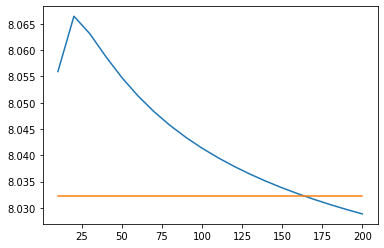

In [ ]:

n = 20

# Model Parameters 
S = 20
K = 18
r = 0.15
T = 12/12
v = 0.80
style = 'euro'
type  = 'call'

# Initialize area 
optionPrices = np.empty((20,3))

# Populate array
for i in range(0,n):
    steps = (i+1)*10 
    optionPrices[i, 0] = steps
    optionPrices[i, 1] = crr_binomial_tree(S, K, r, T, steps, v, style, type)
    optionPrices[i, 2] = black_scholes(S, K, r, T, steps, v, style, type)


print(optionPrices)
print(optionPrices[2,0]+1)

plt.plot(optionPrices[:,0],optionPrices[:,1], label='CRR Price')
plt.plot(optionPrices[:,0],optionPrices[:,2], label='B-S Price')
plt.show()


## Calculating Option Prices

### Monster Beverage Corp.

In [ ]:
# Monster Beverage 
crr_price = crr_binomial_tree(91.36, 95.00, 0.0007, 150/252, 800, 0.8218, 1)
bs_price  =     black_scholes(91.36, 95.00, 0.0007, 150/252, 100, 0.8218, 1)
print("________________________________________________________________\n")
print("Monster Beverage Corp.")
print("Expiry: June 18th")
print("CRR European Call Price: $" + "{:3.3f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.3f}".format(bs_price))

________________________________________________________________

Monster Beverage Corp.
Expiry: June 18th
CRR European Call Price: $21.416
B-S European Call Price: $21.417


## Carvana 

In [ ]:
# Carvana 
crr_price = crr_binomial_tree(265.32, 267.50, 0.00063, 15/252, 100, 0.6065, 1)
bs_price  =     black_scholes(265.32, 267.50, 0.00063, 15/252, 100, 0.6065, 1)
print("________________________________________________________________\n")
print("Carvana Co.")
print("Expiry: April 16th")
print("CRR European Call Price: $" + "{:3.2f}".format(crr_price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))

________________________________________________________________

Carvana Co.
Expiry: April 16th
CRR European Call Price: $14.59
B-S European Call Price: $14.65


In [ ]:
# Monster Beverage Call Option 
c
bs_price = black_scholes(91.36, 93.00, 0.007, 50/252, 8, 0.8218, 1)
print("________________________________________________________________\n")
print("Monster Beverage Corp.")
print("Expiry: June 18th")
print("CRR European Call Price: $" + "{:3.2f}".format(price))
print("B-S European Call Price: $" + "{:3.2f}".format(bs_price))
print("________________________________________________________________\n")

In [ ]:
price = crr_build_tree(70, 70, 0.08, 3/12, 4, 0.09, -1)
print(price)

## Debugging Pricing Code 

Use some provided examples from coursework online to verify results 
for European and American pricing. 

In [26]:
# Ficticious example from practice question documents (Problem 18.12)
# 
crr_visualize_tree(20, 18, 0.15, 12/12, 4, 0.40, 'amer', 'put')
crr_visualize_tree(20, 18, 0.15, 12/12, 4, 0.40, 'euro', 'put')


Inputs:

T : 12.00 months
t :    4 periods

Tree Parameters:

u : 1.2214
d : 0.8187
p : 0.545

CRR Stock Price Tree:

  20.000   24.428   29.836   36.442   44.511 
     nan   16.375   20.000   24.428   29.836 
     nan      nan   13.406   16.375   20.000 
     nan      nan      nan   10.976   13.406 
     nan      nan      nan      nan    8.987 



CRR Option Price Tree:

   1.288    0.387    0.000    0.000    0.000 
     nan    2.476    0.882    0.000    0.000 
     nan      nan    4.594    2.013    0.000 
     nan      nan      nan    7.024    4.594 
     nan      nan      nan      nan    9.013 


Option Price: $  1.29
______________________________________________________________

Inputs:

T : 12.00 months
t :    4 periods

Tree Parameters:

u : 1.2214
d : 0.8187
p : 0.545

CRR Stock Price Tree:

  20.000   24.428   29.836   36.442   44.511 
     nan   16.375   20.000   24.428   29.836 
     nan      nan   13.406   16.375   20.000 
     nan      nan      nan   10.976   13.406 
    

In [ ]:

crr = crr_binomial_tree(20, 18, 0.15, 12/12, 50, 0.40, 'euro', 'put')
bs = black_scholes(20, 18, 0.15, 12/12, 4, 0.40, 'euro', 'put')
print(bs)
print(crr)

1.1030371926735958
1.0966293266078704


In [25]:
p1 = crr_binomial_tree(20, 18, 0.15, 12/12, 4, 0.40, 'euro', 'put')
p2 = crr_binomial_tree(20, 18, 0.15, 12/12, 4, 0.40, 'amer', 'put')
print(p1)
print(p2)

1.1439727281792482
1.2878611847241705
